In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, auc, roc_curve
from sklearn.linear_model import LogisticRegression

### Case 1: Balanced Dataset

In [24]:
X, y = make_classification(n_samples=10000, 
                           n_features=4, 
                           n_redundant=0, 
                           random_state=42, 
                           weights=[0.5])
# To DataFrame
columns = [f'feat_{i+1}' for i in range(X.shape[1])]
X = pd.DataFrame(X, columns=columns)
y = pd.DataFrame(y, columns=['label'])

df = X.merge(y,left_index=True, right_index=True)

In [25]:
df.sample()

,feat_1,feat_2,feat_3,feat_4,label
8207,0.943167,-0.853618,0.388636,-0.5934,0


In [26]:
train_df, test_df = train_test_split(df, test_size=0.1, shuffle=False)
X_train, y_train = train_df[X.columns], train_df[y.columns[0]]
X_test, y_test = test_df[X.columns], test_df[y.columns[0]]

In [27]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [28]:
def evaluation(clf, X, y):
    y_predict_proba = clf.predict_proba(X)[:, 1]
    
    precision, recall, pr_thresholds = precision_recall_curve(y, y_predict_proba)
    fpr, tpr, roc_thresholds = roc_curve(y, y_predict_proba)
    
    return{
        'ROC AUC': auc(fpr, tpr), # Alternatively: roc_auc_score(y, y_predict_proba)
        'PR AUC': auc(recall, precision), # Alternatively (with slight difference): average_precision_score(y, y_predict_proba)
        "precision": precision,
        "recall": recall,
        "pr_thresholds": pr_thresholds,
        "tpr": tpr,
        "fpr": fpr,
        "roc_thresholds": roc_thresholds
    }

In [29]:
evals_train_balanced = evaluation(clf, X_train, y_train)
print(f"ROC AUC: {evals_train_balanced['ROC AUC']}, PR AUC: {evals_train_balanced['PR AUC']}")

ROC AUC: 0.9488691535252812, PR AUC: 0.9410024055042296


In [30]:
evals_test_balanced = evaluation(clf, X_test, y_test)
print(f"ROC AUC: {evals_test_balanced['ROC AUC']}, PR AUC: {evals_test_balanced['PR AUC']}")

ROC AUC: 0.953169335834175, PR AUC: 0.9377326624603982


### Case 2: Unbalanced Dataset

In [31]:
X, y = make_classification(n_samples=10000, 
                           n_features=4, 
                           n_redundant=0, 
                           random_state=42, 
                           weights=[0.9])
# To DataFrame
columns = [f'feat_{i+1}' for i in range(X.shape[1])]
X = pd.DataFrame(X, columns=columns)
y = pd.DataFrame(y, columns=['label'])

df = X.merge(y,left_index=True, right_index=True)

In [32]:
train_df, test_df = train_test_split(df, test_size=0.1, shuffle=False)
X_train, y_train = train_df[X.columns], train_df[y.columns[0]]
X_test, y_test = test_df[X.columns], test_df[y.columns[0]]

In [33]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [34]:
eval_train_imbalanced = evaluation(clf, X_train, y_train)
print(f"ROC AUC: {eval_train_imbalanced['ROC AUC']}, PR AUC: {eval_train_imbalanced['PR AUC']}")

ROC AUC: 0.9325527987637363, PR AUC: 0.7045278360634368


In [35]:
eval_test_imbalanced = evaluation(clf, X_test, y_test)
print(f"ROC AUC: {eval_test_imbalanced['ROC AUC']}, PR AUC: {eval_test_imbalanced['PR AUC']}")

ROC AUC: 0.9613000145741545, PR AUC: 0.7173812596081262


PR VS ROC: PR is better for class imbalances, particularly if we want to treat positive classes with greater weight

# Plot

In [48]:
def plot_precision_recall(ax, title, precision, recall, threshold, auc):
    ax.set_title(title)
    ax.set_xlabel("recall")
    ax.set_ylabel("precision")
    curve = ax.plot(recall, precision, label = f"AUC: {auc:.3f}")
    ax.legend()
    
def plot_roc(ax, title, tpr, fpr, threshold, auc):
    ax.set_title(title)
    ax.set_xlabel("false positive rate")
    ax.set_ylabel("true positive rate")
    curve = ax.plot(fpr, tpr, label = f"AUC: {auc:.3f}")
    ax.legend()

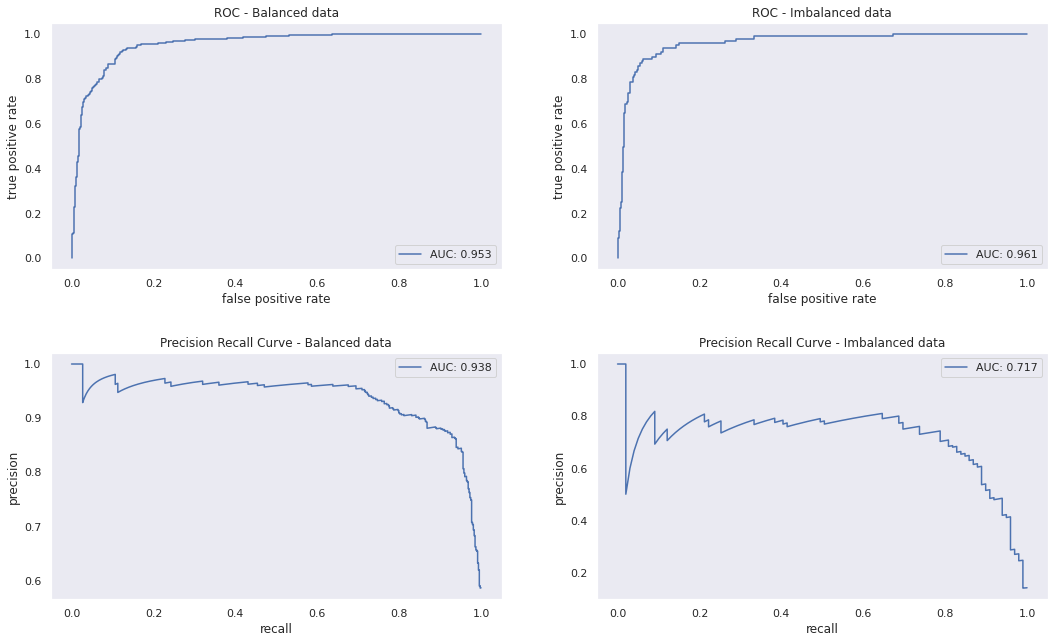

In [60]:
sns.set_style("dark")
plt.rcParams['figure.figsize'] = [16, 10]

fig, axs = plt.subplots(2,2)
fig.tight_layout(pad=5.0)

plot_roc(axs[0,0], "ROC - Balanced data", evals_test_balanced["tpr"],
                     evals_test_balanced["fpr"], evals_test_balanced["roc_thresholds"], evals_test_balanced["ROC AUC"])
plot_roc(axs[0,1], "ROC - Imbalanced data", eval_test_imbalanced["tpr"],
                     eval_test_imbalanced["fpr"], eval_test_imbalanced["roc_thresholds"], eval_test_imbalanced["ROC AUC"])
plot_precision_recall(axs[1,0], "Precision Recall Curve - Balanced data", evals_test_balanced["precision"],
                     evals_test_balanced["recall"], evals_test_balanced["pr_thresholds"], evals_test_balanced["PR AUC"])
plot_precision_recall(axs[1,1], "Precision Recall Curve - Imbalanced data", eval_test_imbalanced["precision"],
                     eval_test_imbalanced["recall"], eval_test_imbalanced["pr_thresholds"], eval_test_imbalanced["PR AUC"])